## Terms for Use
Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.  Note that data providers may have changed their APIs or data formats after this notebook was published.

### Boring Details
The code cells below set up the notebook environment and load necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os
import json
import re
from pprint import pprint
import numpy as np
import pandas as pd
from dateutil.parser import parse # To convert strings to timestamps
import warnings
import urllib3
http = urllib3.PoolManager()
GFC_HOME = os.path.abspath("../../..")
auth_file_path = os.path.join(GFC_HOME, "src", "resources", "auth.json")
with open(os.path.join(GFC_HOME, auth_file_path), "r") as f:
    api_key_dict = json.load(f)
data_path = os.path.join(GFC_HOME, "data")

## ACLED
Armed Conflict Location & Event Data Project (ACLED); acleddata.com

ACLED provides an API that is documented at https://www.acleddata.com/wp-content/uploads/dlm_uploads/2017/10/API-User-Guide.pdf.

ACLED queries return JSON by default but the user can specify other formats, such as CSV.

### Example: ACLED Battle Deaths in Yemen
In this example we will retrieve the battle deaths in Yemen for March 2019.  Every query must include the query parameter `terms=accept`.  Other query terms act as filters on what is searched and what is returned.  In our case we will set the country to Yemen, the event_type to Battle, and the dates to the range for March 2019.

In [11]:
acled_url = "https://api.acleddata.com/acled/read?terms=accept"
starttime = "2019-03-01"
endtime = "2019-03-31"
country = "yemen"
event_type = "battle"
query_url = acled_url + "&country={}".format(country)
query_url += "&event_type={}".format(event_type)
query_url += "&event_date={}|{}&event_date_where=BETWEEN".format(starttime, endtime)
query_url += "&field=iso|fatalities"
#query_url += "&export_type=csv"
print("Query URL: {}".format(query_url))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    r = http.request("GET", query_url)
raw_data = r.data.decode()

Query URL: https://api.acleddata.com/acled/read?terms=accept&country=yemen&event_type=battle&event_date=2019-03-01|2019-03-31&event_date_where=BETWEEN&field=iso|fatalities


We can try to use the eval command to convert the raw_data to a dict, but....

In [12]:
try:
    _data = eval(raw_data)
    _data.keys()
except NameError as e:
    print(repr(e))

NameError("name 'true' is not defined",)


As with the EIA data we have some values that cause a problem for `eval`.  Let's use regex to fix them

In [5]:
raw_data = re.sub("true", "\"true\"", raw_data)
_data = eval(raw_data)
_data.keys()

dict_keys(['success', 'count', 'last_update', 'status', 'filename', 'data'])

The data that we want is in the field helpfully named `data` and contains a list of dicts, each of which describes an event.  Let's look at an example:

In [6]:
_data = _data["data"]
pprint(_data[0])

{'actor1': 'Military Forces of Yemen (2016-) Supreme Political Council',
 'actor2': 'National Resistance Forces',
 'admin1': 'Al Hudaydah',
 'admin2': 'At Tuhayat',
 'admin3': '',
 'assoc_actor_1': '',
 'assoc_actor_2': 'Giants Brigade',
 'country': 'Yemen',
 'data_id': '5121681',
 'event_date': '2019-03-31',
 'event_id_cnty': 'YEM30120',
 'event_id_no_cnty': '30120',
 'event_type': 'Battles',
 'fatalities': '0',
 'geo_precision': '2',
 'inter1': '1',
 'inter2': '3',
 'interaction': '13',
 'iso': '887',
 'iso3': 'YEM',
 'latitude': '14.1836',
 'location': 'At Tuhayta',
 'longitude': '43.2264',
 'notes': 'Pro-Houthi forces reportedly fired artillery and Howitzer shells, '
          'mortars, B-10s, RPGs and snipers at anti-Houthi Giants forces in '
          'Tuhayta district in the south of Hodeidah city, western Yemen, with '
          'no report of fatalities nor injuries.',
 'region': 'Middle East',
 'source': 'Al Amaliqah',
 'source_scale': 'National',
 'sub_event_type': 'Armed cla

Let's produce a data frame from the data:

In [7]:
acled_df = pd.DataFrame(_data, index=[x["data_id"] for x in _data])
acled_df.drop("data_id", axis=1, inplace=True)
acled_df.head()

,actor1,actor2,admin1,admin2,admin3,assoc_actor_1,assoc_actor_2,country,event_date,event_id_cnty,...,location,longitude,notes,region,source,source_scale,sub_event_type,time_precision,timestamp,year
5121681,Military Forces of Yemen (2016-) Supreme Polit...,National Resistance Forces,Al Hudaydah,At Tuhayat,,,Giants Brigade,Yemen,2019-03-31,YEM30120,...,At Tuhayta,43.2264,Pro-Houthi forces reportedly fired artillery a...,Middle East,Al Amaliqah,National,Armed clash,1,1554760629,2019
5121682,National Resistance Forces,Military Forces of Yemen (2016-) Supreme Polit...,Al Hudaydah,Al Hali,,Giants Brigade,,Yemen,2019-03-31,YEM30119,...,Al Hudaydah-Madinat al Salah,42.9940,Anti-Houthi Giants Brigade and Guardians of th...,Middle East,Al Amaliqah,National,Armed clash,1,1554760629,2019
5121683,National Resistance Forces,Military Forces of Yemen (2016-) Supreme Polit...,Al Hudaydah,Al Hali,,Guardians of the Republic,,Yemen,2019-03-31,YEM30118,...,Al Hudaydah-Al Matahin,43.0110,Anti-Houthi Guardians of the Republic forces c...,Middle East,Khabar News Agency (Yemen),National,Armed clash,1,1554760629,2019
5121684,Military Forces of Yemen (2016-) Supreme Polit...,Military Forces of Yemen (2012-),Al Bayda,Mukayras,,,Militia (Pro-Government),Yemen,2019-03-31,YEM30116,...,Mukayras,45.6707,Pro-Houthi forces claimed to have attacked pro...,Middle East,Ofq News,National,Armed clash,1,1554760629,2019
5121688,Bayt al Asnaj Tribal Militia (Yemen),Bayt al Dughaysh Tribal Militia (Yemen),Taizz,Ash Shamayatayn,,,,Yemen,2019-03-31,YEM30131,...,As Samsarah,44.0048,Clashes between Bayt Al-Asnaj and Bayt Al-Dugh...,Middle East,Al Masdar,National,Armed clash,1,1554760629,2019


Suppose we want to obtain the fatalities by day.  We can use pandas groupby to do this:

In [8]:
fatalities_ser = acled_df.groupby("event_date").apply(lambda x: x["fatalities"].sum())
fatalities_ser.head()

event_date
2019-03-01       00101010110555
2019-03-02    01001000000000010
2019-03-03           0101000010
2019-03-04         110000101010
2019-03-05             25250252
dtype: object

That's just wrong.  The problem is that the value in `fatalities` is a string; we need to coerce it to an int and try again.  While we're at it, we should make sure that the values for `event_date` are indeed dates

In [9]:
acled_df["fatalities"] = acled_df["fatalities"].apply(int)
acled_df["event_date"] = acled_df["event_date"].apply(parse)
fatalities_ser = acled_df.groupby("event_date").apply(lambda x: x["fatalities"].sum())
fatalities_ser.head()

event_date
2019-03-01    56
2019-03-02    30
2019-03-03    30
2019-03-04    23
2019-03-05    77
dtype: int64

And we can now plot the daily counts

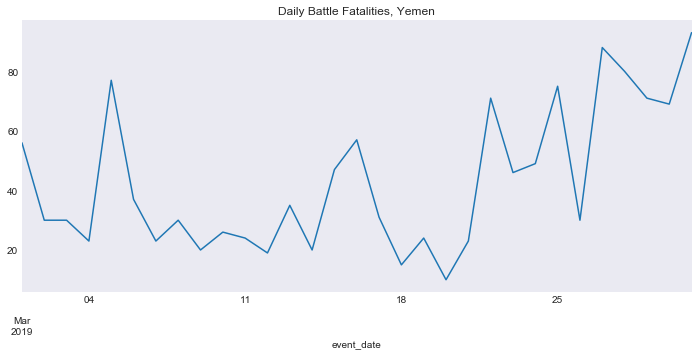

In [10]:
fatalities_ser.plot(figsize=(12,5), title="Daily Battle Fatalities, Yemen");